# seasonal ARIMA model on flight passengers data 

ARIMA (Autoregressive Integrated Moving Average) is a forecasting technique that projects the future values of a series based entirely on its own inertia.

In [1]:
#Import modules
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm  
import warnings
import itertools

# Load data and set 'Month' as DatetimeIndex
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')

# Resample by month and fill missing values by 0
data = data.resample('1MS').sum()


In [326]:
# Get yearly peaks
def get_peaks(data):
    last = '00-00-00'
    max = [0, 0]
    peaks = {}

    for index, row in data.iterrows():
        if index.year == last:
            if row['#Passengers'] >= max[1]:
                max = [index, row['#Passengers']]
        else:
            peaks[max[0]] = max[1]
            last = index.year
            max = [index, row['#Passengers']]

    peaks[max[0]] = max[1]
    return peaks

# 1. Visualize data

Before we start with our model, we can observe the original data. Some trends or variations can be clearly visible

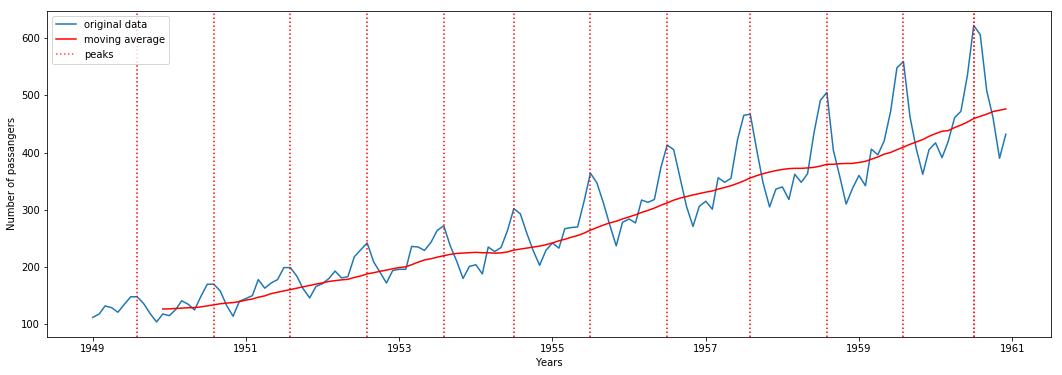

In [327]:
# plot original data with moving average (indicating trend) and peaks (indicating seasonality)
moving_average = data.rolling(12).mean()

pyplot.figure(figsize=(18,6))
pyplot.plot(data, label = 'original data')
pyplot.plot(moving_average, 'r', label = 'moving average')

for xc in get_peaks(data):
    if xc!=0:
        pyplot.axvline(x=xc, c = 'red', ls =':')
        
pyplot.axvline(x=xc, c = 'red', ls =':',alpha=0.7, label = 'peaks')        
pyplot.legend(loc='upper left')       
pyplot.xlabel('Years')
pyplot.ylabel('Number of passangers')
pyplot.show()   




# 2. Test stationarity

The first step in applying ARIMA methodology is to check for stationarity. 
Stationarity is a propertie of time series when serie do not depend on the time (trend and seasonality rule out stationarity)

One of ways to check stationarity is Augmented Dickey-Fuller test. The null hypothesis states that there is a unit root and series is therefore non stationary.
If P-value is lower than 0,05 the null hypothesis can be rejected.


In [351]:
# The Augmented Dickey-Fuller test 
result = adfuller(data['#Passengers'])
outcome = 'stationary'
if result[1] > 0.05:
    outcome = 'not stationary'
print("P-value of Dickey Fuller test is:",result[1], "hence series is",outcome, "with 95% confidence")

P-value of Dickey Fuller test is: 0.9918802434376409 hence series is not stationary with 95% confidence


Stationarity can be also observed from data (clear trend or seasonality)

<Figure size 432x288 with 0 Axes>

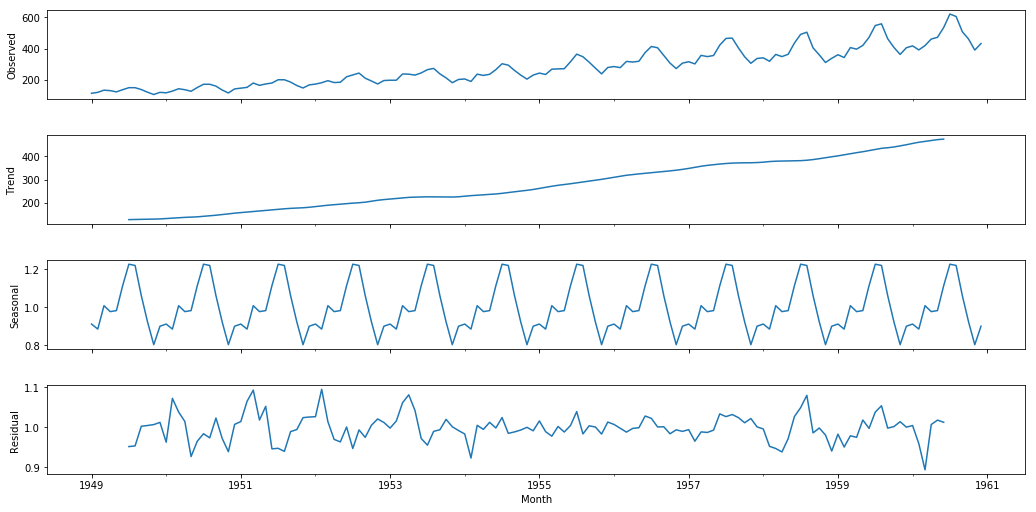

In [329]:
# By decomposing time series different parts are vsible
# Visualize trend and seasonality
result = seasonal_decompose(data, model= 'multiplicative')
fig = pyplot.figure() 
fig = result.plot()  
fig.set_size_inches(16, 8)

# 3. Stationarize the series

Since ARIMA works only on data with stable or consistent pattern over time with a minimum amount of outliers, we must
fisr stationarize the series. Without these stationarity conditions being met, many of the calculations can't be computed.

Differencing is an excellent way of transforming a nonstationary series to a stationary one. This is done by subtracting the observation in the current period from the previous one. If this transformation is done only once to a series, you say that the data has been "first differenced". 




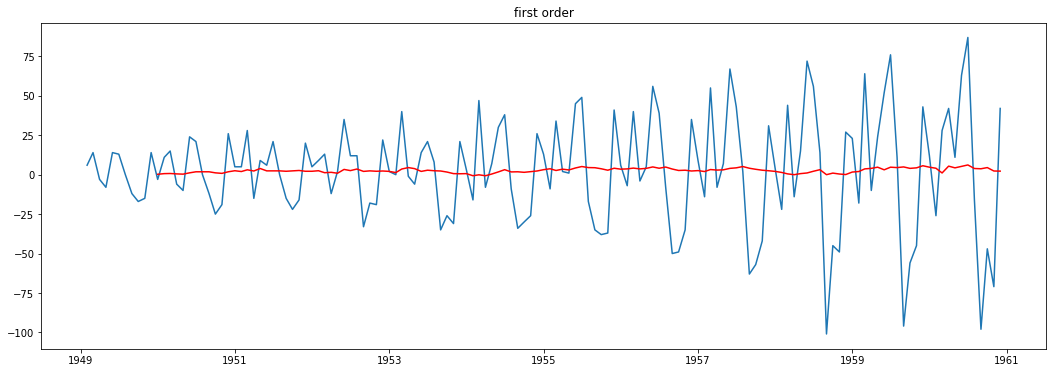

P-value of Dickey Fuller test is: 0.0542  hence series is not stationary with 95% confidnce


In [2]:
# Try fisrt difference
diff_data =  data.diff(1).dropna()
moving_average = diff_data.rolling(12).mean() 


#Visualize
pyplot.figure(figsize=(18,6))
pyplot.plot(diff_data)
pyplot.plot(moving_average, 'r')
pyplot.title('first order')
pyplot.show()

#Test
result = adfuller(diff_data['#Passengers'])
outcome = 'stationary'
if result[1] > 0.05:
    outcome = 'not stationary'
print("P-value of Dickey Fuller test is:","{:.3}".format(result[1]), " hence series is",outcome, "with 95% confidnce")




Since first difference did not make our series stationary, we will try add seasonal difference. (difference by 12 lags)

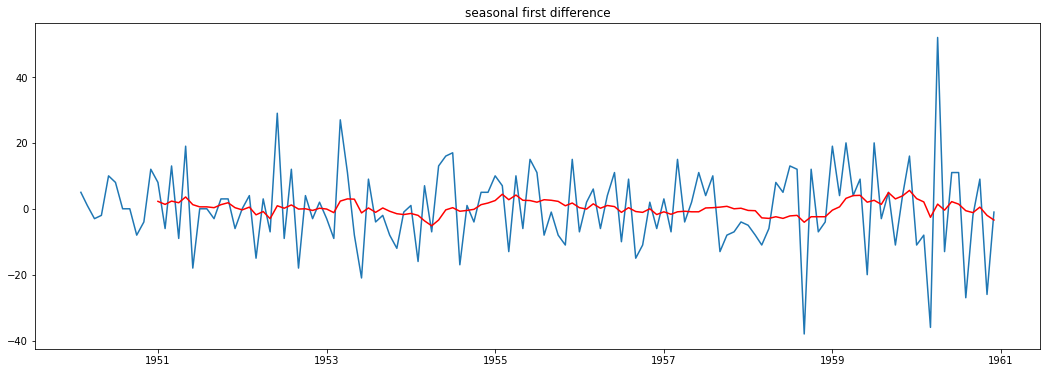

P-value od Dickey Fuller test is: 1.86e-28  hence series is stationary with 95% confidence


In [347]:
# Try first difference of the seasonal difference
seas_first_diff = diff_data.diff(12).dropna()
moving_average = seas_first_diff.rolling(12).mean() 

#Visualize
pyplot.figure(figsize=(18,6))
pyplot.plot(seas_first_diff)
pyplot.plot(moving_average, 'r')
pyplot.title('seasonal first difference')
pyplot.show()

#Test
result = adfuller(seas_first_diff['#Passengers'])
outcome = 'stationary'
if result[1] > 0.05:
    outcome = 'not stationary'
print("P-value od Dickey Fuller test is:","{:.3}".format(result[1]), " hence series is",outcome, "with 95% confidence") 

With p-value way below 0,05 we made our serie stationary

# 4. Find optimal parameters

If we want to fit time series in ARIMA model we need to find parameters ARIMA(p,d,g)(P,D,Q,s).
Autocorrelation and Partial Autocorrelation functions will help estimate the parameters

Autocorrelation Function (ACF): measure of the correlation between the Time series and a lagged version of itself. 


Text(0.5,1,'Autocorrelation Function')

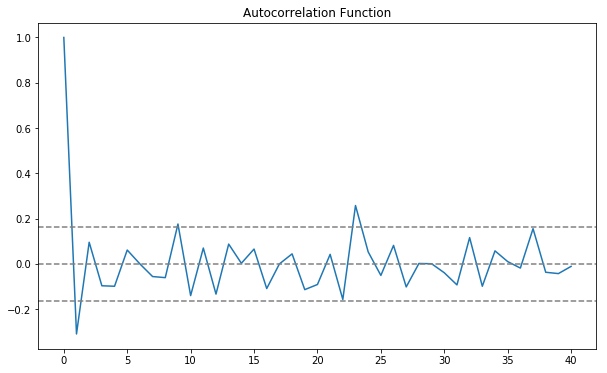

In [332]:
#Plot ACF: 
ac_function = acf(seas_first_diff, nlags=40)
pyplot.figure(figsize=(10,6))
pyplot.plot(ac_function)
pyplot.axhline(y=0,ls='--',c='gray')

#Confident intervals
pyplot.axhline(y=-1.96/np.sqrt(len(data)),ls='--',c='gray')
pyplot.axhline(y=1.96/np.sqrt(len(data)),ls='--',c='gray')

pyplot.title('Autocorrelation Function')

Partial Autocorrelation Function (PACF): measures the correlation between the Time series and a lagged version 
of itself but after eliminating the variations already explained by the intervening comparisons


Text(0.5,1,'Partial Autocorrelation Function')

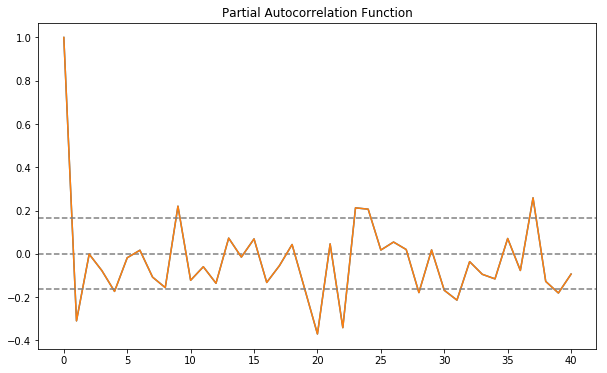

In [333]:
#Plot PACF:
pac_function = pacf(seas_first_diff, nlags=40, method='ols')
pyplot.figure(figsize=(10,6))
pyplot.plot(pac_function)
pyplot.axhline(y=0,ls='--',c='gray')
pyplot.plot(pac_function)

#Confident intervals
pyplot.axhline(y=-1.96/np.sqrt(len(data)),ls='--',c='gray')
pyplot.axhline(y=1.96/np.sqrt(len(data)),ls='--',c='gray')

pyplot.title('Partial Autocorrelation Function')



Both ACF and PCF cross confident intervals around lag 1 for the first time
Thats why we will try different combinations of 0,1 parameters in order (p,d,q) and seasonal order(P,D,Q,s)

(p = non-seasonal AR order, 
 d = non-seasonal differencing, 
 q = non-seasonal MA order, 
 P = seasonal AR order, 
 D = seasonal differencing,
 Q = seasonal MA order, 
 S = period of seasonality)

In [334]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") 
best_result = [(0,0,0),(0,0,0,0),5000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < best_result[2]:
                best_result[1]=param_seasonal
                best_result[2]=results.aic
                best_result[0]=param
               
        except:
            continue
print(best_result[0],best_result[1], best_result[2])

(0, 1, 1) (1, 1, 1, 12) 920.3192974988726


Parameters with best outcome have lowest AIC

# 5. Fit model

Now we can fit our model with chosen parameters and check the summary


In [335]:
mod = sm.tsa.statespace.SARIMAX(data, order=best_result[0], seasonal_order=best_result[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print (results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.160
Date:                            Tue, 21 Aug 2018   AIC                            920.319
Time:                                    14:06:28   BIC                            931.368
Sample:                                01-01-1949   HQIC                           924.805
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285   

We can notice that AIC is indeed as low as we were expecting and all parameters are significant (P>|z|)

 We check if ARIMA model can be improved by examining residual (should be uncorrelated and normally distributed )

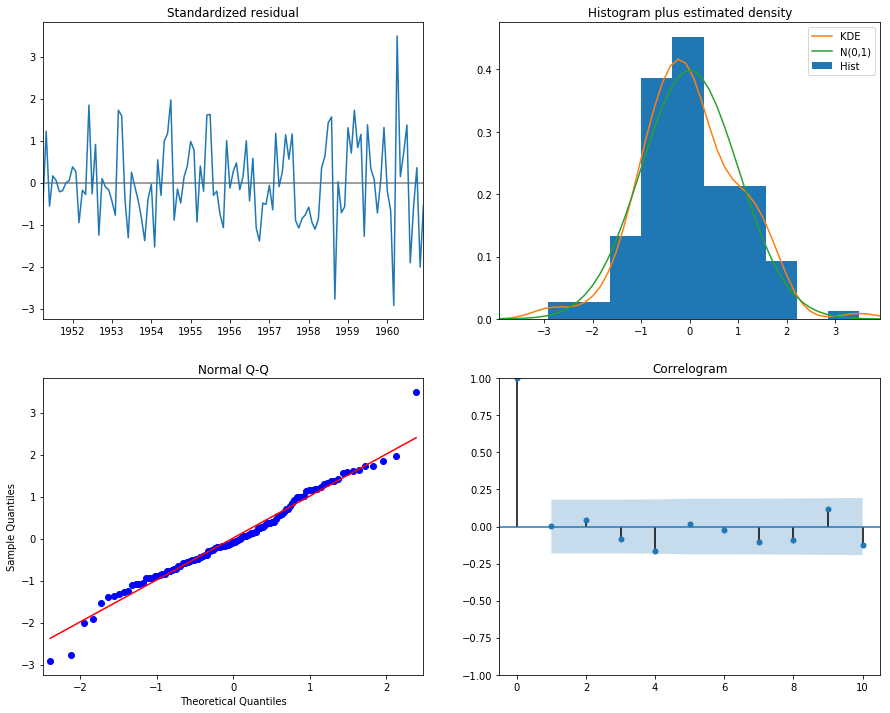

In [336]:
results.plot_diagnostics(figsize=(15, 12))
pyplot.show()


No corrolation is visible from correlogram and also on first plot where is no visible seasonality. Normal distribution can be observed from second and third plot where our sample follows line of normal distribution.(N(0,1))

# 6. Make predictions
Finally we can use our fitted model to make predictions

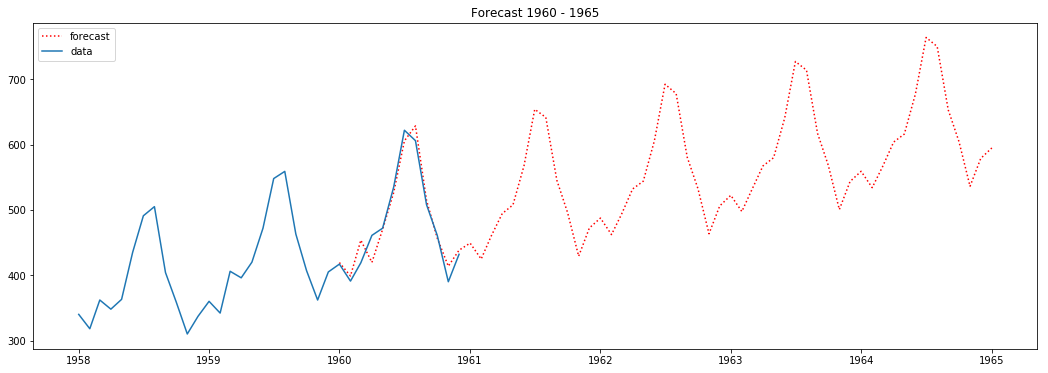

In [339]:
# Plot forecast from 1960 - 1965
forecast = results.predict(start = '1960-01-01', end= '1965-01-01')  
pyplot.figure(figsize=(18,6))
pyplot.plot(forecast, 'r', ls=':', label = 'forecast')
pyplot.plot(data['1958':], label ='data')
pyplot.title('Forecast 1960 - 1965')
pyplot.legend(loc='upper left') 
pyplot.show()
